In [ ]:
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip -uq    '/content/drive/MyDrive/dataset.zip'

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('/content/drive/MyDrive/ps2model.h5')

In [ ]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import itertools
import cv2
# from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense,Flatten
from keras.layers.convolutional import Conv2D
import argparse
from keras.models import Sequential,load_model
from keras.layers import Activation,MaxPooling2D,Dropout,Dense
import os
from keras.layers import BatchNormalization

In [ ]:
import cv2
import matplotlib.pyplot as plt

def extractor(img):
    p=0
    net = cv2.dnn.readNetFromDarknet("/content/drive/MyDrive/yolov3_custom.cfg", "/content/drive/MyDrive/yolov3/yolov3_training_final.weights")
    classes = ['Licence Plate']
    img = cv2.resize(img, (1280, 720))
    hight, width, _ = img.shape
    blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)

    output_layers_name = net.getUnconnectedOutLayersNames()

    layerOutputs = net.forward(output_layers_name)

    boxes = []
    confidences = []
    class_ids = []
    cropped = None
    for output in layerOutputs:
        for detection in output:
            score = detection[5:]
            class_id = np.argmax(score)
            confidence = score[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * hight)
                w = int(detection[2] * width)
                h = int(detection[3] * hight)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                if(confidence>p):
                  p=confidence
                  cropped = img[y:y + h, x:x + w]
                boxes.append([x, y, w, h])
                confidences.append((float(confidence)))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, .8, .4)
    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(boxes), 3))
    if(len(indexes)==0):
      return img
    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))
            color = (0, 255, 0)    
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label + " " + confidence, (x, y + 400), font, 2, color, 2)
    return img

In [ ]:
def vid_capture(cap):
  net = cv2.dnn.readNetFromDarknet("/content/drive/MyDrive/yolov3_custom.cfg", "/content/drive/MyDrive/yolov3/yolov3_training_final.weights")
  classes = ['Licence Plate']
  p=0
  cropped=None
  flag=1
  while cap.isOpened():
      print('Detecting')
      _, img = cap.read()
      img=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
      img = cv2.resize(img, (1280, 720))
      hight, width, _ = img.shape
      blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
      net.setInput(blob)
      output_layers_name = net.getUnconnectedOutLayersNames()
      layerOutputs = net.forward(output_layers_name)
      boxes = []
      confidences = []
      class_ids = []
      for output in layerOutputs:
          for detection in output:
              score = detection[5:]
              class_id = np.argmax(score)
              confidence = score[class_id]
              if confidence > 0.5:
                  center_x = int(detection[0] * width)
                  center_y = int(detection[1] * hight)
                  w = int(detection[2] * width)
                  h = int(detection[3] * hight)
                  x = int(center_x - w / 2)
                  y = int(center_y - h / 2)
                  if confidence>p:
                    p=confidence
                    cropped=img[y:y+h,x:x+w]
                    if p>0.5:
                      flag=0
                  boxes.append([x, y, w, h])
                  confidences.append((float(confidence)))
                  class_ids.append(class_id)
      indexes = cv2.dnn.NMSBoxes(boxes, confidences, .8, .4)
      font = cv2.FONT_HERSHEY_PLAIN
      colors = np.random.uniform(0, 255, size=(len(boxes), 3))
      if len(indexes) > 0:
          for i in indexes.flatten():
              x, y, w, h = boxes[i]
              label = str(classes[class_ids[i]])
              confidence = str(round(confidences[i], 2))
              color = colors[i]
              cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
              cv2.putText(img, label + " " + confidence, (x, y + 400), font, 2, color, 2)
      if(flag==0):
        break
  return cropped


In [ ]:
def get_processed_image(img):
    a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return a

In [ ]:
def cmp(a):
  return ord(a)

In [ ]:
def cmp1(a):
  M=cv2.moments(a)
  return int(M['m10']/M['m00'])

In [ ]:
import numpy as np
import cv2
import imutils
def locate_candidates(img,imgg):
  ans=[]
  img=cv2.resize(img,(300,100))
  img=cv2.GaussianBlur(img, (5,5),0)
  #light=cv2.morphologyEx(img,cv2.MORPH_CLOSE,sqr_kernel)
  #img=cv2.Canny(img,0,120)
  thresh=cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,115,8)
  contours,hierarchy=cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
  cv2.drawContours(image,contours,-1,(0,255,0),1)
  le=len(contours)
  print (len(contours))
  cnt=[]
  for i in contours:
    M1=cv2.moments(i)
    M1=M1['m00']
    if (M1==0):
       continue
    else:
      cnt.append(i)    
  contours=sorted(cnt,key=cmp1)
  
  avl=[]
  
  print('###'+str(len(cnt)))
  hr=-1
  cnt=0
  for i in contours:
     x,y,w,h=cv2.boundingRect(i)
     if (w > thresh.shape[1] /16 and w < thresh.shape[1] /8 and h > thresh.shape[0] /6 and h<(3*thresh.shape[0])/4):
       if(cnt>2):
        hr=h
        break
     cnt+=1
  for i in contours:
      x,y,w,h=cv2.boundingRect(i)
      cropped = imgg[y:y + h, x:x + w]
      cv2.waitKey(0)
      if (w > thresh.shape[1] /16 and w < thresh.shape[1] /8 and h > thresh.shape[0] /6 and h<(3*thresh.shape[0])/4) or hr!=-1:
        M=cv2.moments(i)
      else:
        continue
      fl=1
      cx=int(M['m10']/M['m00'])
      for j in avl:
          if abs(j-cx)<=10:
              fl=0
          if(fl==0):
              break

      if(fl==0):
          continue
      if((w > thresh.shape[1] /16 and w < thresh.shape[1] /8 and h > thresh.shape[0] /6 and h<(3*thresh.shape[0])/4) or abs(h-hr)<=6  ):
        avl.append(cx)
      if (w > thresh.shape[1] /16 and w < thresh.shape[1] /8 and h > thresh.shape[0] / 6 and h<(3*thresh.shape[0])/4) or (abs(h-hr)<=6  and w < thresh.shape[1] /8):
        cropped=imgg[y:y+h,x:x+w]
        cropped=cv2.copyMakeBorder(cropped, 5, 5, 5, 5, cv2.BORDER_CONSTANT)
        ans.append(cropped)
  

        
  return ans




In [ ]:
mapping='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [ ]:
features=[]
labels=[]
li=[]
path = '/content/dataset'
for c in os.listdir(path):
  li.append(c)
li.sort(key=cmp)
print(li)
index=0
for c in li:
  print(c)
  folder = os.path.join(path,c)
  for img in os.listdir(folder):
        imgpath = os.path.join(folder,img)
        i = cv2.imread(imgpath)
        imgfinal = get_processed_image(i)
        imgfinal = np.array(imgfinal)
        features.append(imgfinal)
        labels.append(index)
  index+=1 
    

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
0
1
2
3
4
5
6
7
8
9
A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z


In [ ]:
labels=np.array(labels)
features=np.array(features)
print(labels.shape)
print(features.shape)

(36576,)
(36576, 28, 28)


In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.3,random_state=42,shuffle=True,stratify=labels)

In [ ]:
print(len(x_train),len(x_test)) 

25603 10973


In [ ]:
np.save('x_train',x_train)
np.save('y_train',y_train)
np.save('x_test',x_test)
np.save('y_test',y_test)

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_train = x_train.reshape((25603, 28, 28, 1))
x_test=x_test.reshape((10973, 28, 28, 1))
print(x_test.shape)

x_train = x_train/255
x_test = x_test/255

(10973, 28, 28, 1)


In [ ]:
from tensorflow import keras
y_test = keras.utils.to_categorical(y_test, 36)
y_train = keras.utils.to_categorical(y_train, 36)

In [ ]:

model =Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape = (28,28,1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(36, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('/content/models/model-{epoch:03d}.h5',
                                 monitor='accuracy',
                                 verbose=0,
                                 save_best_only=True)

In [ ]:
history=model.fit(x_train,y_train,callbacks=[checkpoint],validation_data = None,epochs=100,verbose=1,batch_size=64)


Epoch 1/100
401/401 [==============================] - 14s 10ms/step - loss: 1.3294 - accuracy: 0.7240
Epoch 2/100
401/401 [==============================] - 4s 9ms/step - loss: 0.3073 - accuracy: 0.9158
Epoch 3/100
401/401 [==============================] - 4s 9ms/step - loss: 0.1975 - accuracy: 0.9408
Epoch 4/100
401/401 [==============================] - 4s 9ms/step - loss: 0.1430 - accuracy: 0.9553
Epoch 5/100
401/401 [==============================] - 4s 9ms/step - loss: 0.1111 - accuracy: 0.9649
Epoch 6/100
401/401 [==============================] - 4s 9ms/step - loss: 0.0941 - accuracy: 0.9695
Epoch 7/100
401/401 [==============================] - 4s 9ms/step - loss: 0.0784 - accuracy: 0.9740
Epoch 8/100
401/401 [==============================] - 4s 9ms/step - loss: 0.0765 - accuracy: 0.9761
Epoch 9/100
401/401 [==============================] - 4s 9ms/step - loss: 0.0606 - accuracy: 0.9799
Epoch 10/100
401/401 [==============================] - 4s 9ms/step - loss: 0.0647 - accu

In [ ]:
# predictions = model.predict_classes(x_test)
predictions = np.argmax(model.predict(x_test),axis=-1)


Detecting


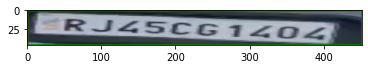

In [ ]:
cap=cv2.VideoCapture('/content/drive/MyDrive/Vid_1.mp4')
vimg=vid_capture(cap)
plt.imshow(vimg,cmap='Greys_r')

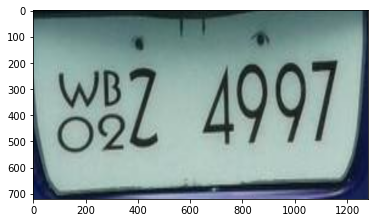

In [ ]:
image= cv2.imread('/content/drive/MyDrive/ps2/test_pics/t11.png')
#image=vimg
image=extractor(image)
plt.imshow(image,cmap='Greys_r')
image=cv2.resize(image,(300,100))
imgg=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
imgg=cv2.medianBlur(imgg,  5)
cv2.imwrite('vv.jpeg',imgg)
#imgg=cv2.Canny(imgg,0,120)
kernel = np.ones((3,3),np.uint8)
imgg=cv2.adaptiveThreshold(imgg,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,21,12)
#imgg =cv2.morphologyEx(imgg, cv2.MORPH_CLOSE, kernel)
imgg=cv2.erode(imgg,kernel,1)
#imgg=cv2.dilate(imgg,kernel,1)
#plt.imshow(imgg,cmap='Greys_r')
gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

23
###21


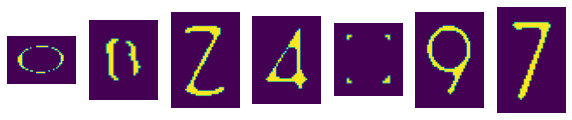

In [ ]:
import cv2
from matplotlib import pyplot as plt
ans=locate_candidates(gray,imgg)
rows=1
columns=len(ans)
cnt=1
fig = plt.figure(figsize=(10, 7))
for i in ans:
  fig.add_subplot(rows,columns,cnt)
  plt.imshow(i)
  plt.axis('off')
  cnt+=1

@7
(28, 28)
W(28, 28)
W(28, 28)
W(28, 28)
W(28, 28)
W(28, 28)
W(28, 28)
W

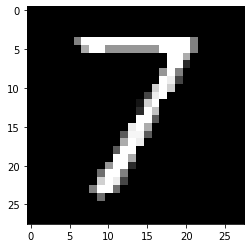

In [ ]:
import cv2
import matplotlib.pyplot as plt
cnt = 0
print('@'+str(len(ans)))
for test_image in ans:
  #test_image=cv2.bitwise_not(test_image)
  test_image=cv2.resize(test_image,(28,28))
  print(test_image.shape)
  plt.imshow(test_image,cmap='Greys_r')
  x=np.reshape(test_image,(28,28,1))/255
  y=[x]
  y=np.array(y)
  result=np.argmax(model.predict(y))
  if (cnt>=0 and cnt<=1) or (cnt>=4 and cnt<=4):
    if result==0:
      result=24
    elif result==8:
      result=11  
    elif result==2:
      result=35
    elif result==4:
      result=21
    elif result==5:
      result=28 
    elif result==6:
      result=16
    elif result==1:
      result=18    
  else:
    if result==24:
      result=0
    elif result==11:
      result=8 
    elif result==35:
      result=2  
    elif result==21:
      result=4  
    elif result==28:
      result=5
    elif result==16:
      result=6
    elif result==18:
      result=1      
  print(mapping[result],end='')
  cnt+=1


In [ ]:
model.save('/content/drive/My Drive/ps2model.h5')